# 버트를 활용한 한국어 텍스트 분류 모델

* 네이버 영화 리뷰 데이터 기반

In [16]:
import os
import re
import numpy as np
from tqdm import tqdm

import tensorflow as tf
from transformers import *

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

import pandas as pd
import matplotlib.pyplot as plt

# 사전학습 모델 CACHE DIR 설정
os.environ['TRANSFORMERS_CACHE'] = '/data/huggingface/transformers'

In [3]:
#random seed 고정
tf.random.set_seed(1234)
np.random.seed(1234)

BATCH_SIZE = 32
NUM_EPOCHS = 3
VALID_SPLIT = 0.2
MAX_LEN = 39 # EDA에서 추출된 Max Length

## 네이버 영화 리뷰 데이터 전처리

### 데이터  확보

In [22]:
DATA_TRAIN_PATH = os.path.join('./data', "naver_movie", "ratings_train.txt")

train_data = pd.read_csv(DATA_TRAIN_PATH, header = 0, delimiter = '\t', quoting = 3)
train_data = train_data.dropna()
train_data.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [5]:
from transformers import *
tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')

In [6]:
def bert_tokenizer(sent, MAX_LEN):
    
    encoded_dict = tokenizer.encode_plus(
        text = sent,
        add_special_tokens = True, # ADD [CLS], [SEP]
        max_length = MAX_LEN,
        pad_to_max_length = True,
        return_attention_mask = True, 
        truncation=True
    )
    
    input_id = encoded_dict['input_ids']
    attention_mask = encoded_dict['attention_mask']
    token_type_id = encoded_dict['token_type_ids']
    
    return input_id, attention_mask, token_type_id

### Tokenizer 테스트

In [7]:
print(tokenizer.all_special_tokens, '\n', tokenizer.all_special_ids)

['[UNK]', '[SEP]', '[PAD]', '[CLS]', '[MASK]'] 
 [100, 102, 0, 101, 103]


In [8]:
kor_encode = tokenizer.encode('안녕하세요, 반갑습니다')
kor_decode = tokenizer.decode(kor_encode)
print(kor_encode)
print(kor_decode)

[101, 9521, 118741, 35506, 24982, 48549, 117, 9321, 118610, 119081, 48345, 102]
[CLS] 안녕하세요, 반갑습니다 [SEP]


In [9]:
eng_encode = tokenizer.encode('Hello world')
eng_decode = tokenizer.decode(eng_encode)
print(eng_encode)
print(eng_decode)

[101, 31178, 11356, 102]
[CLS] Hello world [SEP]


### 영화 데이터 전처리

In [41]:
input_ids = []
attention_masks = []
token_type_ids = []
train_data_labels = []

for train_sent, train_label in zip(train_data['document'], train_data['label']):
    input_id, attention_mask, token_type_id = bert_tokenizer(train_sent, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    train_data_labels.append(train_label)
    
train_movie_input_ids = np.array(input_ids, dtype=int)
train_movie_attention_masks = np.array(attention_masks, dtype=int)
train_movie_token_type_ids = np.array(token_type_ids, dtype=int)
train_movie_inputs = (train_movie_input_ids, train_movie_attention_masks, train_movie_token_type_ids)

train_data_labels = np.asarray(train_data_labels, dtype=np.int32)

print('# sent: {}, # labels: {}'.format(len(train_movie_input_ids), len(train_data_labels)))

# sent: 149995, # labels: 149995


In [11]:
print(train_movie_input_ids[1])
print(train_movie_attention_masks[1])
print(train_movie_token_type_ids[1])
print(train_data_labels[1])
print(tokenizer.decode(train_movie_input_ids[1]))

[   101    100    119    119    119   9928  58823  30005  11664   9757
 118823  30858  18227 119219    119    119    119    119   9580  41605
  25486  12310  20626  23466   8843 118986  12508   9523  17196  16439
    102      0      0      0      0      0      0      0      0]
[1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0
 0 0]
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0]
1
[CLS] [UNK]... 포스터보고 초딩영화줄.... 오버연기조차 가볍지 않구나 [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]


## 학습

In [28]:
class TFBertClassifier(tf.keras.Model):
    
    def __init__(self, model_name, num_class):
        super(TFBertClassifier, self).__init__()
        
        self.bert = TFBertModel.from_pretrained(model_name)
        self.dropout = tf.keras.layers.Dropout(self.bert.config.hidden_dropout_prob)
        
        initializer = tf.keras.initializers.TruncatedNormal(self.bert.config.initializer_range)
        self.classifier = tf.keras.layers.Dense(num_class, 
                                                kernel_initializer=initializer,
                                                name='classifier')
    def call(self, inputs, attention_mask=None, token_type_ids=None, training=False):
        
        outputs = self.bert(inputs, attention_mask=attention_mask, token_type_ids=token_type_ids)
        
        pooled_output = outputs[1]
        pooled_output = self.dropout(pooled_output, training=training)
        logits = self.classifier(pooled_output)
        
        return logits

cls_model = TFBertClassifier(model_name='bert-base-multilingual-cased', num_class=2)  

Some layers from the model checkpoint at bert-base-multilingual-cased were not used when initializing TFBertModel: ['mlm___cls', 'nsp___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-multilingual-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


In [29]:
optimizer = tf.keras.optimizers.Adam(3e-5) # for fine-tuning
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
metric = tf.keras.metrics.SparseCategoricalAccuracy('accuracy')
cls_model.compile(optimizer=optimizer, loss=loss, metrics=[metric])

In [30]:
model_name = "tf2_bert_naver_movie"

# overfitting을 막기 위한 ealrystop 추가
earlystop_callback = EarlyStopping(monitor='val_accuracy', min_delta=0.0001,patience=2)
# min_delta: the threshold that triggers the termination (acc should at least improve 0.0001)
# patience: no improvment epochs (patience = 1, 1번 이상 상승이 없으면 종료)\

DATA_OUT_PATH = 'train_output'
checkpoint_path = os.path.join(DATA_OUT_PATH, model_name, 'weights.h5')
checkpoint_dir = os.path.dirname(checkpoint_path)
  
cp_callback = ModelCheckpoint(
    checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

# 학습과 eval 시작
history = cls_model.fit(train_movie_inputs, train_data_labels, epochs=NUM_EPOCHS, batch_size=BATCH_SIZE,
                    validation_split = VALID_SPLIT, callbacks=[earlystop_callback, cp_callback])

#steps_for_epoch

print(history.history)

Epoch 1/3
3750/3750 [==============================] - ETA: 0s - loss: 0.4111 - accuracy: 0.8087WARNING:tensorflow:The parameters `output_attentions`, `output_hidden_states` and `use_cache` cannot be updated when calling a model.They have to be set to True/False in the config object (i.e.: `config=XConfig.from_pretrained('name', output_attentions=True)`).

Epoch 00001: val_accuracy improved from -inf to 0.84929, saving model to train_output/tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 706s 188ms/step - loss: 0.4111 - accuracy: 0.8087 - val_loss: 0.3397 - val_accuracy: 0.8493
Epoch 2/3
3750/3750 [==============================] - ETA: 0s - loss: 0.3206 - accuracy: 0.8605
Epoch 00002: val_accuracy improved from 0.84929 to 0.85890, saving model to train_output/tf2_bert_naver_movie/weights.h5
3750/3750 [==============================] - 706s 188ms/step - loss: 0.3206 - accuracy: 0.8605 - val_loss: 0.3340 - val_accuracy: 0.8589
Epoch 3/3
3750/3750 [==========

In [45]:
def plot_graphs(history, string):
    plt.plot(history.history[string])
    plt.plot(history.history['val_'+string], '')
    plt.xlabel("Epochs")
    plt.ylabel(string)
    plt.legend([string, 'val_'+string])
    plt.show()

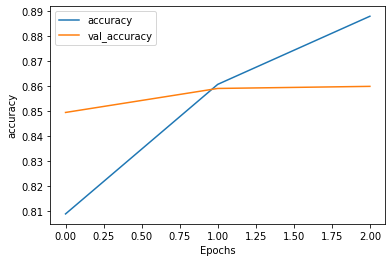

In [46]:
plot_graphs(history, 'accuracy')

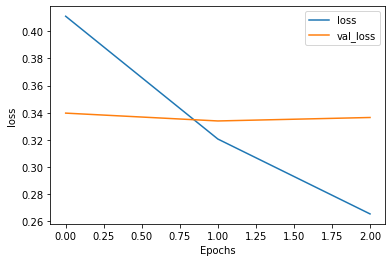

In [47]:
plot_graphs(history, 'loss')

### Test 데이터

In [23]:
DATA_TEST_PATH = os.path.join('./data', "naver_movie", "ratings_test.txt")
test_data = pd.read_csv(DATA_TEST_PATH, header = 0, delimiter = '\t', quoting = 3)
test_data = test_data.dropna()
test_data.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [34]:
len(test_data)

49997

In [43]:
input_ids = []
attention_masks = []
token_type_ids = []
test_data_labels = []

for test_sent, test_label in tqdm(zip(test_data["document"], test_data["label"])):
    input_id, attention_mask, token_type_id = bert_tokenizer(test_sent, MAX_LEN)
    input_ids.append(input_id)
    attention_masks.append(attention_mask)
    token_type_ids.append(token_type_id)
    test_data_labels.append(test_label)

test_movie_input_ids = np.array(input_ids, dtype=int)
test_movie_attention_masks = np.array(attention_masks, dtype=int)
test_movie_type_ids = np.array(token_type_ids, dtype=int)
test_movie_inputs = (test_movie_input_ids, test_movie_attention_masks, test_movie_type_ids)

test_data_labels = np.asarray(test_data_labels, dtype=np.int32) #레이블 토크나이징 리스트

print("num sents, labels {}, {}".format(len(test_movie_input_ids), len(test_data_labels)))

49997it [00:09, 5108.17it/s]

num sents, labels 49997, 49997


In [44]:
results = cls_model.evaluate(test_movie_inputs, test_data_labels, batch_size=1024)
print("test loss, test acc: ", results)

49/49 [==============================] - 63s 1s/step - loss: 0.3426 - accuracy: 0.8540
test loss, test acc:  [0.34260472655296326, 0.8539512157440186]
